# Import Library

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import pearsonr

import time
from sklearn import preprocessing

# Load the Drive helper and mount
from google.colab import drive
from google.colab import files

# This will prompt for authorization.
drive.mount('/content/drive')

from tqdm import tqdm
tqdm.pandas()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [0]:
df = pd.read_excel ('drive/My Drive/Colab Notebooks/credit_scoring/cs_train.xlsx')

## Split between feature data and target data

In [0]:
# Pisahkan antara feature data dengan target data
feature_df = df.drop(['CREDIT_SCORE'],axis=1)
target_df = df['CREDIT_SCORE']

## Get basic information

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
STATUS_OF_EXISTING_CHECKING_ACCOUNT                         895 non-null object
DURATION_IN_MONTH                                           897 non-null float64
CREDIT_HISTORY                                              899 non-null object
PURPOSE                                                     900 non-null object
CREDIT_AMOUNT                                               899 non-null float64
SAVINGS_ACCOUNT/BONDS                                       898 non-null object
PRESENT_EMPLOYMENT_SINCE                                    900 non-null object
INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME         899 non-null float64
PERSONAL_STATUS_AND_SEX                                     898 non-null object
OTHER_DEBTORS/GUARANTORS                                    898 non-null object
PRESENT_RESIDENCE_SINCE                                     900 non-null int64
PROPERTY     

Bisa dilihat bahwa total ada 21 kolom, dengan tipe data integer, float dan object. Dari total baris berjumlah 900 entries, terdapat beberapa kolom yang mengalami missing values. Dan penggunaan memori oleh data ini adalah 147.7 KB

## Show sample from feature data

In [0]:
feature_df.head(3)

,STATUS_OF_EXISTING_CHECKING_ACCOUNT,DURATION_IN_MONTH,CREDIT_HISTORY,PURPOSE,CREDIT_AMOUNT,SAVINGS_ACCOUNT/BONDS,PRESENT_EMPLOYMENT_SINCE,INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME,PERSONAL_STATUS_AND_SEX,OTHER_DEBTORS/GUARANTORS,PRESENT_RESIDENCE_SINCE,PROPERTY,AGE_IN_YEARS,OTHER_INSTALLMENT_PLANS,HOUSING,NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK,JOB,NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENANCE_FOR,TELEPHONE,FOREIGN_WORKER
0,A11,6.0,A34,A43,1169.0,A65,A75,4.0,A93,A101,4,A121,67.0,A143,A152,2.0,A173,1.0,A192,A201
1,A12,48.0,A32,A43,5951.0,A61,A73,2.0,A92,A101,2,A121,22.0,A143,A152,1.0,A173,1.0,A191,A201
2,A14,12.0,A34,A46,2096.0,A61,A74,2.0,A93,A101,3,A121,49.0,A143,A152,1.0,A172,2.0,A191,A201


## Check Data Type each column

In [0]:
print ("data types:\n", feature_df.dtypes)

data types:
 STATUS_OF_EXISTING_CHECKING_ACCOUNT                          object
DURATION_IN_MONTH                                           float64
CREDIT_HISTORY                                               object
PURPOSE                                                      object
CREDIT_AMOUNT                                               float64
SAVINGS_ACCOUNT/BONDS                                        object
PRESENT_EMPLOYMENT_SINCE                                     object
INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME         float64
PERSONAL_STATUS_AND_SEX                                      object
OTHER_DEBTORS/GUARANTORS                                     object
PRESENT_RESIDENCE_SINCE                                       int64
PROPERTY                                                     object
AGE_IN_YEARS                                                float64
OTHER_INSTALLMENT_PLANS                                      object
HOUSING                            

## Check Distribution Plot numerical data

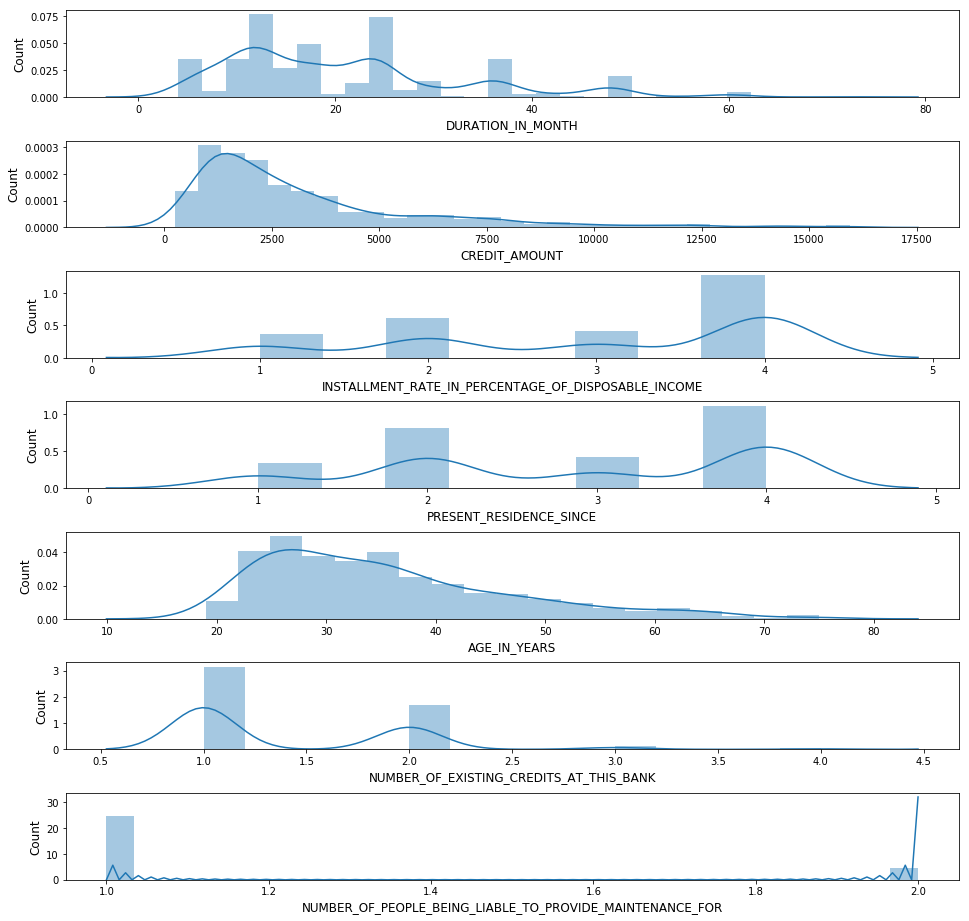

In [0]:
numerical = feature_df.select_dtypes(exclude=['object'])
col_names = numerical.columns

fig, ax = plt.subplots(len(col_names), figsize=(16,16))
fig.subplots_adjust(hspace=.5)

for i, col_val in enumerate(col_names):

    sns.distplot(numerical[col_val].dropna(), hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=12)
    ax[i].set_ylabel('Count', fontsize=12)

plt.show()

Dari hasil distribusi plot diatas terlihat feature berikut ini :

"**INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME**" , 

"**PRESENT_RESIDENCE_SINCE**", 

"**NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK**" dan 

"**NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENANCE_FOR**"

merupakan **categorical data** (namun direpresentasikan dengan nilai numerik), oleh karena itu akan kita ubah tipe data-nya dari **float64/int64** menjadi **category** 

## Convert data type (Object -> Category)
Kita melakukan convert tipe data karena computing time untuk data tipe **category** lebih cepat dibanding **object**



In [0]:
# Convert object type to category type
for col in feature_df.columns:
  if feature_df[col].dtypes == 'O':
    feature_df[col] = feature_df[col].astype('category')

# Convert float64/int64 to category type
convert = ['INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME', 'PRESENT_RESIDENCE_SINCE', 'NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK', 'NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENANCE_FOR']
for col in convert:
  feature_df[col] = feature_df[col].astype('category')
  
target_df = target_df.astype('category')

##Split Numerical and Categorical Dataframe

In [0]:
num_feature_df = feature_df.select_dtypes(exclude=['category'])
cat_feature_df = feature_df.select_dtypes(include=['category'])

## Check numerical data distribution plot

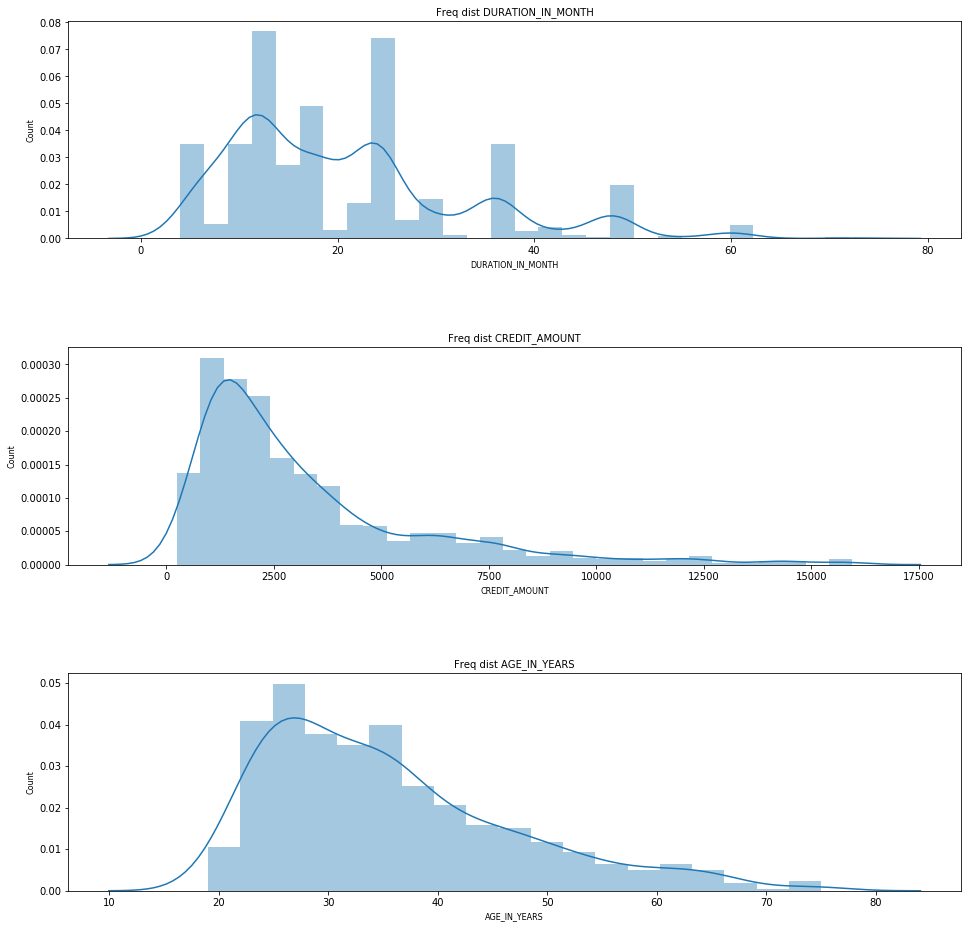

In [0]:
# Check numerical data distribution plot
col_names = num_feature_df.columns

fig, ax = plt.subplots(len(col_names), figsize=(16,16))
fig.subplots_adjust(hspace=.5)

for i, col_val in enumerate(col_names):

    sns.distplot(num_feature_df[col_val].dropna(), hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

Terlihat bahwa ketiga distribusi data diatas mengalami skew positif, maka nanti akan kita lakukan transformasi datanya agar bentuk distribusinya mendekati distribusi normal

##Visualize Target Distribution

Jumlah LAYAK diberikan pinjaman:  632
Jumlah TIDAK LAYAK diberikan pinjaman:  268


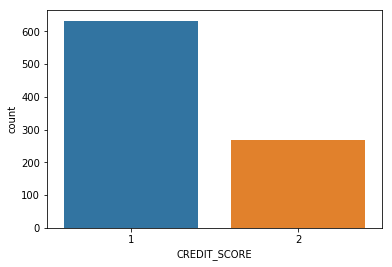

In [0]:
ax = sns.countplot(target_df, label="Count")
L, T = target_df.value_counts()
print("Jumlah LAYAK diberikan pinjaman: ", L)
print("Jumlah TIDAK LAYAK diberikan pinjaman: ", T)
plt.show()

Dari grafik di atas dapat dilihat bahwa label data tersebut tidak seimbang (Imbalanced Dataset Problem). Data yang terlabel TIDAK LAYAK (warna orange) memiliki jumlah hampir setengahnya dari data yang LAYAK (warna biru).

In [0]:
# Concat feature and target dataframe
data_df = pd.concat([feature_df,target_df], axis=1)

# EDA on CATEGORICAL DATA

##Check total unique value for each feature

In [0]:
# Check total unique value
for col in cat_feature_df.columns:
  print(col,"= ",cat_feature_df[col].dropna().unique())
  print('\n')

STATUS_OF_EXISTING_CHECKING_ACCOUNT =  [A11, A12, A14, A13]
Categories (4, object): [A11, A12, A14, A13]


CREDIT_HISTORY =  [A34, A32, A33, A30, A31]
Categories (5, object): [A34, A32, A33, A30, A31]


PURPOSE =  [A43, A46, A42, A40, A41, A49, A44, A45, A410, A48]
Categories (10, object): [A43, A46, A42, A40, ..., A44, A45, A410, A48]


SAVINGS_ACCOUNT/BONDS =  [A65, A61, A63, A64, A62]
Categories (5, object): [A65, A61, A63, A64, A62]


PRESENT_EMPLOYMENT_SINCE =  [A75, A73, A74, A71, A72]
Categories (5, object): [A75, A73, A74, A71, A72]


INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME =  [4.0, 2.0, 3.0, 1.0]
Categories (4, float64): [4.0, 2.0, 3.0, 1.0]


PERSONAL_STATUS_AND_SEX =  [A93, A92, A91, A94]
Categories (4, object): [A93, A92, A91, A94]


OTHER_DEBTORS/GUARANTORS =  [A101, A103, A102]
Categories (3, object): [A101, A103, A102]


PRESENT_RESIDENCE_SINCE =  [4, 2, 3, 1]
Categories (4, int64): [4, 2, 3, 1]


PROPERTY =  [A121, A122, A124, A123]
Categories (4, object): [

## Check countplot for each categorical data ( For see the most categories for each feature  )

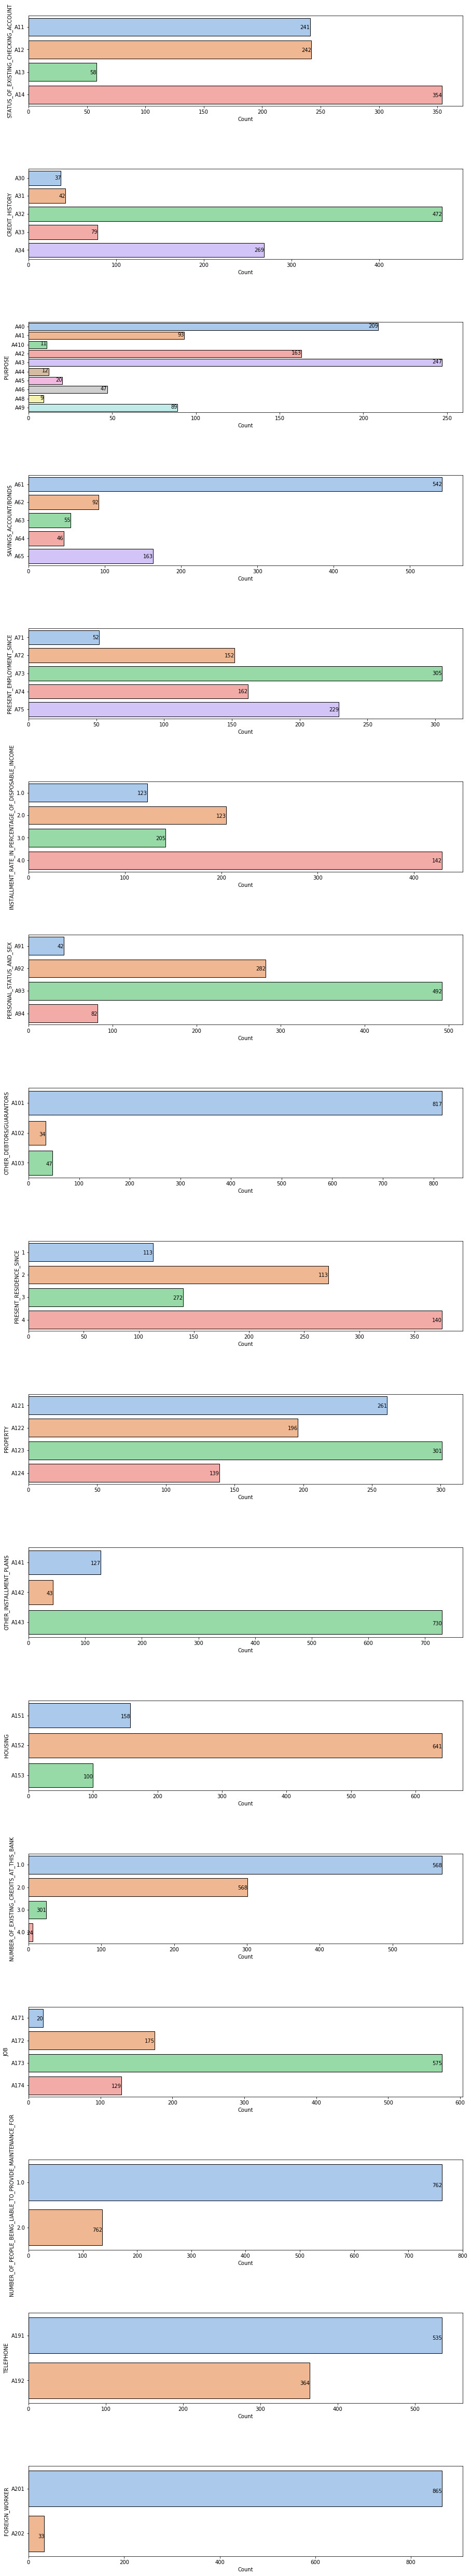

In [0]:
#Countplot Categorical Data
col_names = cat_feature_df.columns

fig, ax = plt.subplots(len(col_names), figsize=(15,90))
fig.subplots_adjust(hspace=0.7)

for i, col_val in enumerate(col_names):

    graph = sns.countplot(y=cat_feature_df[col_val].dropna(), ax=ax[i], edgecolor='black', palette='pastel', orient='v')
    j=0
    for p in graph.patches:
      height = p.get_height()
      graph.text(p.get_width(), p.get_y()+0.5,cat_feature_df[col_val].value_counts()[j],ha="right")
      j+=1
      
    ax[i].set_xlabel('Count', fontsize=10)
    ax[i].set_ylabel(col_val, fontsize=10)

plt.show()

## Check Hypothesis for 'SAVINGS_ACCOUNT/BONDS'

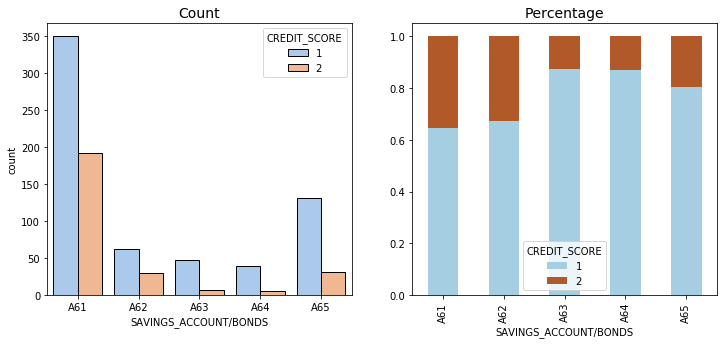

In [0]:
# Hipotesis : semakin besar jumlah tabungan maka persentase pengajuan kredit diterima semakin besar
# Fakta : Jumlah orang yang memiliki tabungan dalam jumlah besar hanya sedikit
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='SAVINGS_ACCOUNT/BONDS', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("SAVINGS_ACCOUNT/BONDS")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Hipotesis ini terbukti dengan nilai Credit_Score yang bernilai "1" memiliki persentase yang lebih besar dibandingka nilai "2" pada A63 dan A64 

## Check Hypothesis for 'PRESENT_EMPLOYMENT_SINCE'

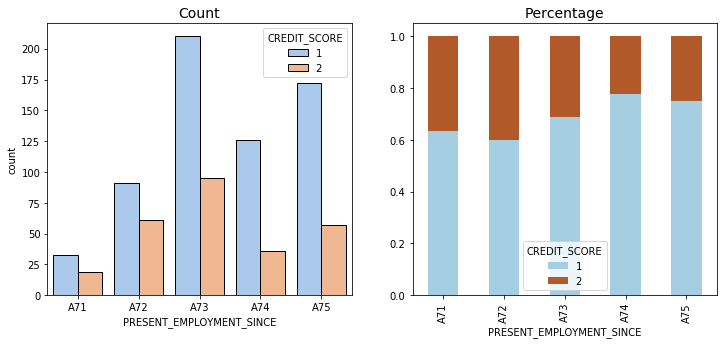

In [0]:
# Hipotesis : semakin lama menjadi karyawan maka kemungkinan pengajuan kredit diterima semakin besar

fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='PRESENT_EMPLOYMENT_SINCE', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("PRESENT_EMPLOYMENT_SINCE")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Hipotesis ini tidak terbukti, lama menjadi karyawan tidak meningkatkan kemungkinan pengajuan kredit diterima. Dan karyawan yang telah bekerja antara 4 sampai 7 tahun memiliki kemungkinan tertinggi pengajuan kreditnya akan diterima

## Check Hypothesis for 'PERSONAL_STATUS_AND_SEX'

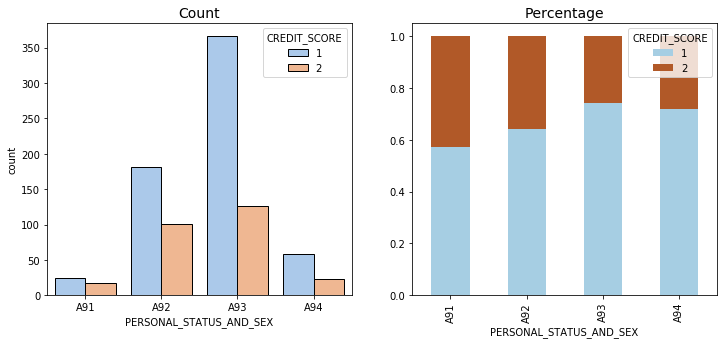

In [0]:
# Hipotesis : pria(single) punya kemungkinan kreditnya diterima lebih tinggi
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='PERSONAL_STATUS_AND_SEX', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("PERSONAL_STATUS_AND_SEX")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Berdasarkan data terlihat bahwa Pria(single) paling banyak mengajukan kredit dan memiliki kemungkinan diterima paling tinggi (walaupun persentasenya tidak berbeda jauh dengan gender dan status lainnya) 

## Check Hypothesis for 'PROPERTY'

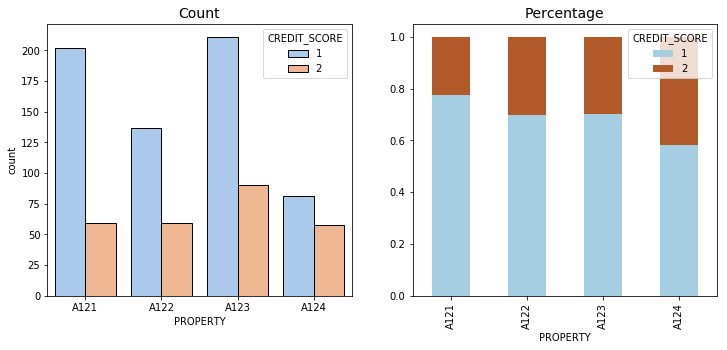

In [0]:
# Hipotesis : semakin mahal property yang dimiliki mempengaruhi persentase penerimaan kredit
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='PROPERTY', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("PROPERTY")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Hipotesis ini terbukti, orang yang punya real estate (A121) memiliki persentase tertinggi pengajuan kreditnya akan diterima sedangkan orang yang tidak memiliki property/tidak diketahui property-nya memiliki persentase penerimaan terendah

## Check Hypothesis for 'HOUSING'

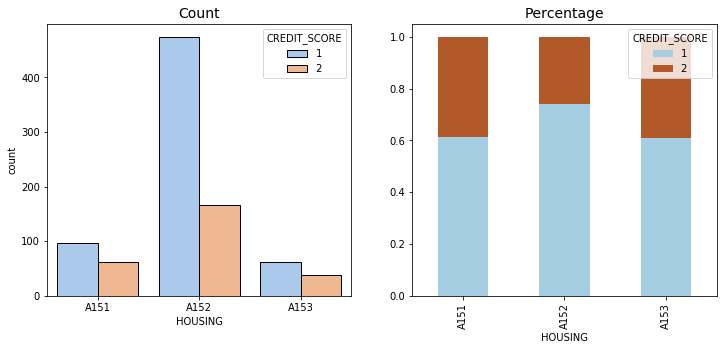

In [0]:
# Hipotesis : orang yang punya tempat tinggal milik pribadi punya kemungkinan penerimaan kredit lebih tinggi
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='HOUSING', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("HOUSING")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Hipotesis ini terbukti

##Check Hypothesis for 'JOB'

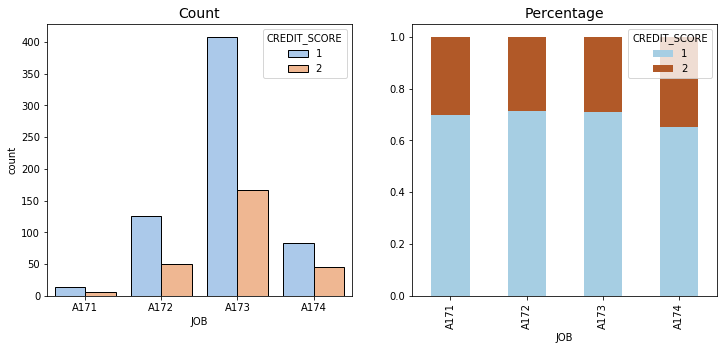

In [0]:
# Hipotesis : jenis pekerjaan tertentu mempengaruhi persentase penerimaan pengajuan kredit
fig, ax =plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='JOB', hue='CREDIT_SCORE',data=data_df, edgecolor='black', palette='pastel', ax=ax[0],)
data_df.groupby("JOB")['CREDIT_SCORE'].value_counts(normalize=True).unstack().plot(kind='bar', stacked='True', colormap='Paired',ax=ax[1])
ax[0].set_title('Count', fontsize=14)
ax[1].set_title('Percentage', fontsize=14)
fig.show()

Hipotesis ini tidak terbukti, karena jenis pekerjaan yang berbeda secara persentase memiliki penerimaan kredit yang kurang lebih mirip

## Hipotesis : feature yang tidak memilih pengaruh/korelasi terhadap target
- TELEPHONE
- FOREIGN_WORKER

Karena itu perlu di check korelasinya, jika rendah maka 2 feature tersebut dapat di drop/buang

# EDA on NUMERICAL DATA

Berikutnya mari kita lihat sisi statistik dari data seperti **variance, standard deviasi, max dan min** . Informasi-informasi tersebut sangat membantu untuk mengerti data.

In [0]:
num_feature_df.describe()

,DURATION_IN_MONTH,CREDIT_AMOUNT,AGE_IN_YEARS
count,897.000000,899.000000,899.000000
mean,20.751394,3246.301446,35.548387
std,12.024787,2789.296824,11.468007
min,4.000000,250.000000,19.000000
25%,12.000000,1346.500000,27.000000
50%,18.000000,2301.000000,33.000000
75%,24.000000,3977.500000,42.000000
max,72.000000,15945.000000,75.000000


##Visualize STATUS_OF_EXISTING_CHECKING ACCOUNT categories proportion

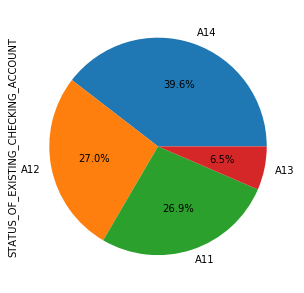

In [0]:
feature_df.STATUS_OF_EXISTING_CHECKING_ACCOUNT.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

Berdasarkan data terlihat sekitar 39.6% - A14 (tidak memiliki akun bank), namun mengajukan permintaan kredit. Hal ini cukup aneh karena ini berarti tidak ada data mengenai gaji per bulan dalam kurun waktu 1 tahun

##Visualize DURATION_IN_MONTH categories proportion

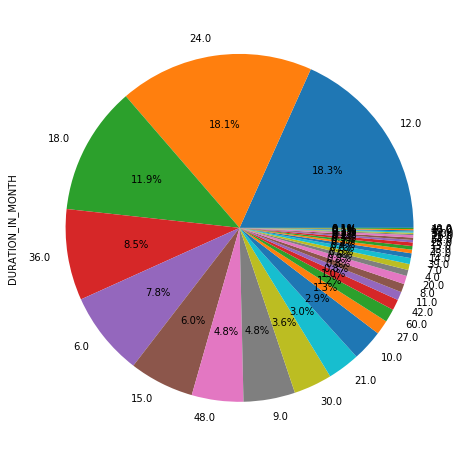

In [0]:
feature_df.DURATION_IN_MONTH.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(8, 8))

Berdasarkan data durasi peminjaman kredit yang banyak dipilih adalah untuk jangka waktu 12 bulan, 24 bulan, dan 18 bulan

## Visualize Purpose categories proportion

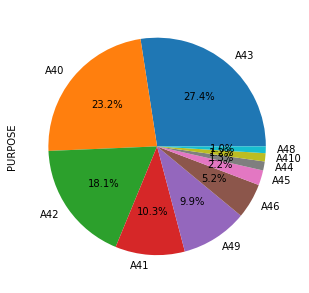

In [0]:
feature_df.PURPOSE.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

Berdasarkan data, tujuan terbanyak dari pengajuan kredit adalah untuk A43(radio/TV), A40(mobil baru), A42(furnitur/perlengkapan)

##Visualize SAVINGS_ACCOUNT/BONDS categories proportion

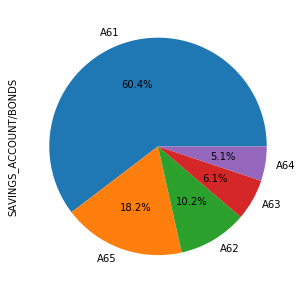

In [0]:
feature_df['SAVINGS_ACCOUNT/BONDS'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

Berdasarkan data terlihat bahwa 60.4%(A61) orang yang mengajukan kredit memiliki jumlah tabungan <100DM dan sebanyak 18.2% (A65) orang tidak memiliki akun tabungan

##Visualize 	PRESENT_EMPLOYMENT_SINCE categories proportion

Jumlah orang yang pengangguran (A71) : 52


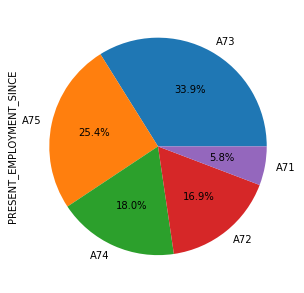

In [0]:
feature_df.PRESENT_EMPLOYMENT_SINCE.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))
print("Jumlah orang yang pengangguran (A71) : " +str(feature_df.PRESENT_EMPLOYMENT_SINCE.value_counts()['A71']))

Berdasarkan data A71 terdapat 5.8% orang pengangguran yang mengajukan kredit, hal ini dapat menjadi pertimbangan pihak bank.

Apakah masih mau melihat faktor" lain dari orang pengangguran ini / langsung me-reject pengajuan kreditnya ? Karena orang yg pengangguran tidak punya penghasilan yang dapat membayar cicilan kredit, kecuali orang tsb memiliki tabungan yang besar/ punya barang yang dapat dijadikan jaminan

Dan sebanyak 33.9% (A73) sudah menjadi karyawan antara 1 - 4 tahun saat orang tsb mengajukan kredit

##Visualize	PERSONAL_STATUS_AND_SEX categories proportion

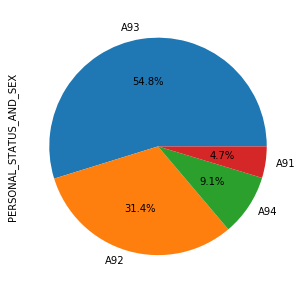

In [0]:
feature_df.PERSONAL_STATUS_AND_SEX.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

54.8% orang yang mengajukan kredit adalah pria (single) dan 31.4% orang yang mengajukan kredit adalah wanita (sudah cerai/sudah menikah)

#Visualize HOUSING categories proportion

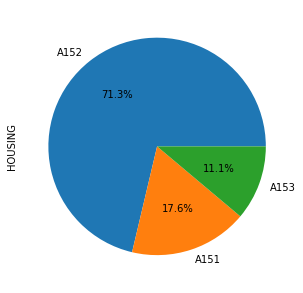

In [0]:
feature_df.HOUSING.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

71.3 % orang memiliki tempat tinggal milik pribadi

# Visualize JOB categories proportion

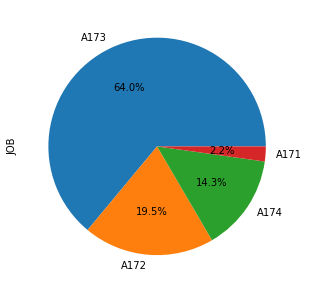

In [0]:
feature_df.JOB.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5, 5))

64% orang yg mengajukan kredit adalah karyawan berpengalaman/pegawai resmi (A173)

## Check Missing Values

In [0]:
print(feature_df.isnull().sum()) #feature data has missing values

STATUS_OF_EXISTING_CHECKING_ACCOUNT                         5
DURATION_IN_MONTH                                           3
CREDIT_HISTORY                                              1
PURPOSE                                                     0
CREDIT_AMOUNT                                               1
SAVINGS_ACCOUNT/BONDS                                       2
PRESENT_EMPLOYMENT_SINCE                                    0
INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME         1
PERSONAL_STATUS_AND_SEX                                     2
OTHER_DEBTORS/GUARANTORS                                    2
PRESENT_RESIDENCE_SINCE                                     0
PROPERTY                                                    3
AGE_IN_YEARS                                                1
OTHER_INSTALLMENT_PLANS                                     0
HOUSING                                                     1
NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK                     1
JOB     

# Find The Outliers Data ( abs(Z-Score )> 3 )

In [0]:
cols = list(num_feature_df.columns)
zscore = pd.DataFrame()
outlier = []
not_outlier = []

for col in cols:
    zscore[col] = np.where( np.abs((num_feature_df[col] - num_feature_df[col].mean())/num_feature_df[col].std(ddof=0)) >3)

for col in zscore.columns:
    status = zscore[col][0] == ()
    if status == False :
        outlier.append(col)
    else :
        not_outlier.append(col)

In [0]:
outlier

['DURATION_IN_MONTH', 'CREDIT_AMOUNT', 'AGE_IN_YEARS']

In [0]:
not_outlier

[]

## Visualize and Check the Outlier

In [0]:
def lower_upper_bound(data):
  data = data.sort_values(ascending=True)
  q1 = data.describe()[4]
  q3 = data.describe()[6]
  iqr = q3-q1
  lower_bound = q1 -(1.5 * iqr) 
  upper_bound = q3 +(1.5 * iqr)
  return lower_bound, upper_bound

>## "DURATION_IN_MONTH" Column




Upper bound : 42.0


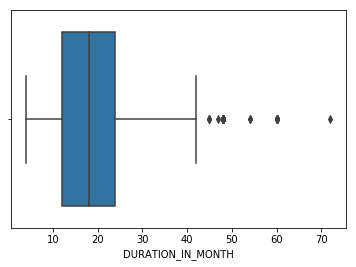

In [0]:
ax = sns.boxplot(x=num_feature_df['DURATION_IN_MONTH'])
lower,upper = lower_upper_bound(num_feature_df['DURATION_IN_MONTH'])
print("Upper bound :",upper)

Berdasarkan nilai upper bound dan hasil box plot terlihat bahwa data durasi peminjaman kredit > 42 bulan merupakan outlier. Namun untuk kasus ini sangat memungkinkan jika terdapat durasi peminjaman > 42 bulan (3.5 tahun) karena pada feature "PURPOSE" ada opsi mobil, bisnis, dll.

Karena itu data outlier ini tidak akan saya drop/buang

In [0]:
# Check korelasi data outlier dengan feature "PURPOSE"
dim_outlier = (num_feature_df['DURATION_IN_MONTH']>upper).value_counts()
print("Jumlah Outlier data : "+ str(dim_outlier[True]))
dim_purpose = pd.DataFrame(df[num_feature_df['DURATION_IN_MONTH']>upper].PURPOSE.value_counts())
dim_purpose['persentase %'] = dim_purpose/dim_outlier[True]*100
dim_purpose.style.format({'persentase %': "{:.2f}"})

Jumlah Outlier data : 61


,PURPOSE,persentase %
A43,16,26.23
A49,15,24.59
A40,12,19.67
A41,8,13.11
A410,3,4.92
A46,3,4.92
A42,3,4.92
A44,1,1.64


TOP 4 pengajuan kredit untuk tujuan : A43(radio/televisi), A49(bisnis), A40(mobil baru), dan A41 (mobil bekas)

Skewness= 1.1092059873069087
Kurtosis= 0.9694934321104758


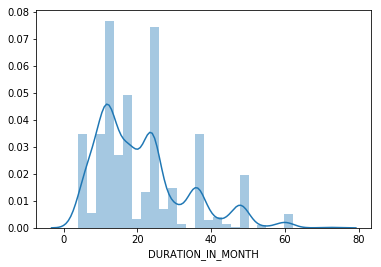

In [0]:
print ('Skewness=',num_feature_df['DURATION_IN_MONTH'].skew())
print ('Kurtosis=',num_feature_df['DURATION_IN_MONTH'].kurt())
sns.distplot(num_feature_df['DURATION_IN_MONTH'].dropna())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Skewness= -0.03897658247715148
Kurtosis= -0.5890162123918672


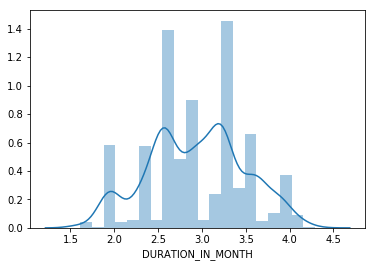

In [0]:
# Log transform for handle skew problem
sns.distplot(num_feature_df['DURATION_IN_MONTH'].dropna().apply(np.log1p))
num_feature_df['DURATION_IN_MONTH'] = num_feature_df['DURATION_IN_MONTH'].apply(np.log1p)
print ('Skewness=',num_feature_df['DURATION_IN_MONTH'].skew())
print ('Kurtosis=',num_feature_df['DURATION_IN_MONTH'].kurt())

>## "CREDIT AMOUNT" Column

Upper bound : 7924.0


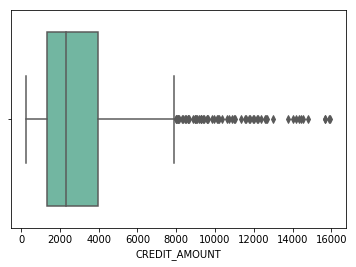

In [0]:
ax = sns.boxplot(x=num_feature_df['CREDIT_AMOUNT'], palette="Set2")
lower,upper = lower_upper_bound(num_feature_df['CREDIT_AMOUNT'])
print("Upper bound :",upper)

Nilai dari data outlier disini cukup masuk akal mengingat untuk kredit mobil, bisnis butuh biaya yang besar

Skewness= 1.8880039460594824
Kurtosis= 3.883095808242427


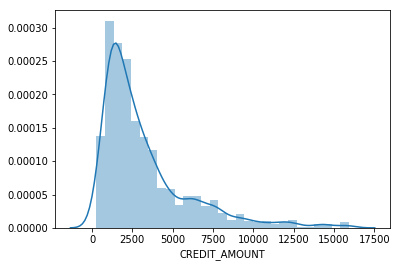

In [0]:
print ('Skewness=',num_feature_df['CREDIT_AMOUNT'].skew())
print ('Kurtosis=',num_feature_df['CREDIT_AMOUNT'].kurt())
sns.distplot(num_feature_df['CREDIT_AMOUNT'].dropna())

Skewness= 0.11833181231388497
Kurtosis= -0.3683742759614921


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


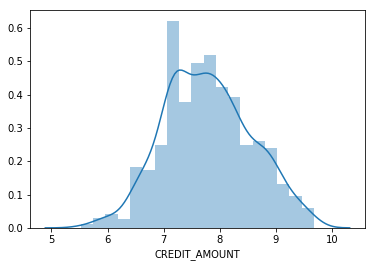

In [0]:
# Log transform for handle skew problem
sns.distplot(num_feature_df['CREDIT_AMOUNT'].dropna().apply(np.log1p))
num_feature_df['CREDIT_AMOUNT'] = num_feature_df['CREDIT_AMOUNT'].apply(np.log1p)
print ('Skewness=',num_feature_df['CREDIT_AMOUNT'].skew())
print ('Kurtosis=',num_feature_df['CREDIT_AMOUNT'].kurt())

>## "AGE IN YEARS" Column

Upper bound :  64.5


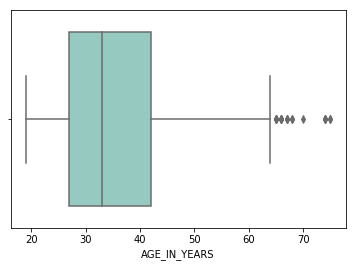

In [0]:
ax = sns.boxplot(x=num_feature_df['AGE_IN_YEARS'],palette="Set3")
lower,upper = lower_upper_bound(num_feature_df['AGE_IN_YEARS'])
print("Upper bound : ",upper)

Skewness= 1.03111231949728
Kurtosis= 0.6060630114938195


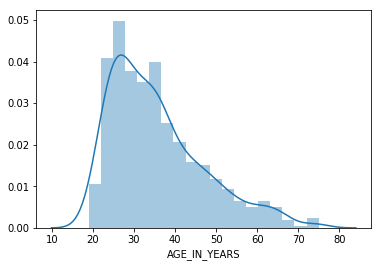

In [0]:
print ('Skewness=',num_feature_df['AGE_IN_YEARS'].skew())
print ('Kurtosis=',num_feature_df['AGE_IN_YEARS'].kurt())
sns.distplot(num_feature_df['AGE_IN_YEARS'].dropna())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Skewness= 0.4414286379304802
Kurtosis= -0.5376404408859261


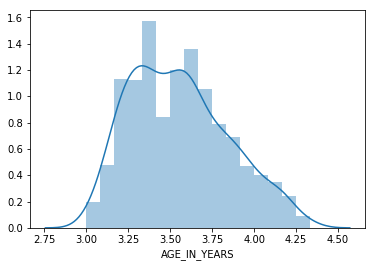

In [0]:
# Log transform for handle skew problem
sns.distplot(num_feature_df['AGE_IN_YEARS'].dropna().apply(np.log1p))
num_feature_df['AGE_IN_YEARS'] = num_feature_df['AGE_IN_YEARS'].apply(np.log1p)
print ('Skewness=',num_feature_df['AGE_IN_YEARS'].skew())
print ('Kurtosis=',num_feature_df['AGE_IN_YEARS'].kurt())

# Handle Missing Values

Jika datanya categorical lebih baik imputasinya menggunakan MODUS 

Jika datanya numerical dan terdapat outlier lebih baik pake MEDIAN

Jika datanya numerical dan tidak ada outlier lebih baik pake MEAN

## Categorical Data

In [0]:
# Handle missing values on categorical data use modus
for col in cat_feature_df.columns:
    imputation = cat_feature_df.mode()[col][0]
    cat_feature_df[col].fillna(value = imputation,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Numerical Data

In [0]:
# Handle missing values in numerical data outlier
for col in outlier:
    imputation1 = num_feature_df.median()[col]
    num_feature_df[col].fillna(value = imputation1,inplace=True)

# Handle missing values in numerical data not outlier
for col in not_outlier:
    imputation2 = num_feature_df.mean()[col]
    num_feature_df[col].fillna(value = imputation2,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [0]:
print(num_feature_df.isnull().sum()) # Missing values already handle
print(cat_feature_df.isnull().sum())

DURATION_IN_MONTH    0
CREDIT_AMOUNT        0
AGE_IN_YEARS         0
dtype: int64
STATUS_OF_EXISTING_CHECKING_ACCOUNT                         0
CREDIT_HISTORY                                              0
PURPOSE                                                     0
SAVINGS_ACCOUNT/BONDS                                       0
PRESENT_EMPLOYMENT_SINCE                                    0
INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME         0
PERSONAL_STATUS_AND_SEX                                     0
OTHER_DEBTORS/GUARANTORS                                    0
PRESENT_RESIDENCE_SINCE                                     0
PROPERTY                                                    0
OTHER_INSTALLMENT_PLANS                                     0
HOUSING                                                     0
NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK                     0
JOB                                                         0
NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENAN

# Standardization Numerical Data

**Normalization** : rescale data sehingga nilainya berkisar antara [0,1]. Namun perlu diingat dengan normalisasi, informasi mengenai outlier data akan menjadi bias, karena memiliki max 1. Jika ada outlier, data yang "normal" akan memiliki interval data yang teramat kecil. Pada kasus di dunia nyata, hampir semua data memiliki outlier.

**Standardization** : rescale data sehingga memiliki mean 0 dan unit variance. Saat menggunakan standardization, data tidak terbatas antara [0,1], namun berapa variance.

Karena itu kita memilih **standardization** pada numerical data

In [0]:
num_feature_df = (num_feature_df - num_feature_df.mean() ) / num_feature_df.std()

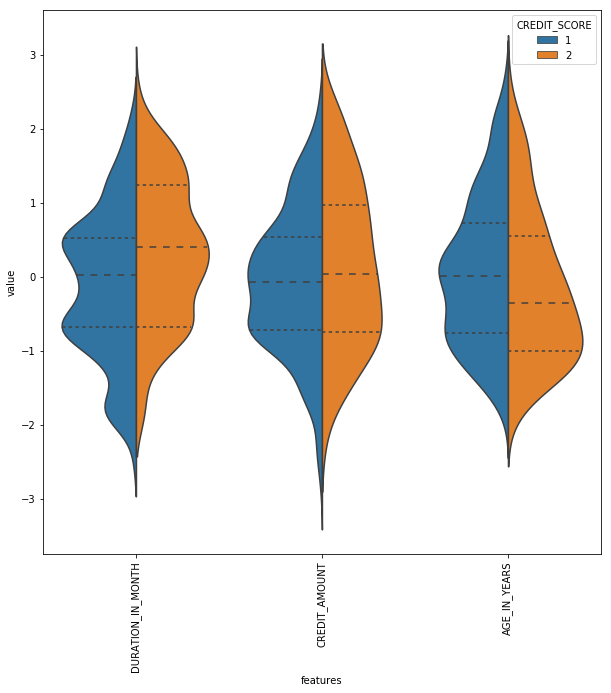

In [0]:
data = pd.concat([target_df, num_feature_df], axis =1)
data = pd.melt(data, id_vars = "CREDIT_SCORE",
                var_name="features",
                value_name="value"
              )
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="CREDIT_SCORE", 
              data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Grafik diatas menggambarkan 'bentuk' distribusi data untung masing-masing feature terhadap target yaitu "CREDIT_SCORE"

Berdasarkan hasil grafik diatas didapat informasi :
* Semua feature menunjukkan bahwa distribusi nilainya tidak terlalu terlihat terpisah

# Visualize Characteristic class of data based on each feature

In [0]:
sns.set(style="whitegrid", palette="muted")
data = pd.concat([target_df,num_feature_df],axis=1)
data = pd.melt(data,id_vars="CREDIT_SCORE",
                    var_name="features",
                    value_name='value')

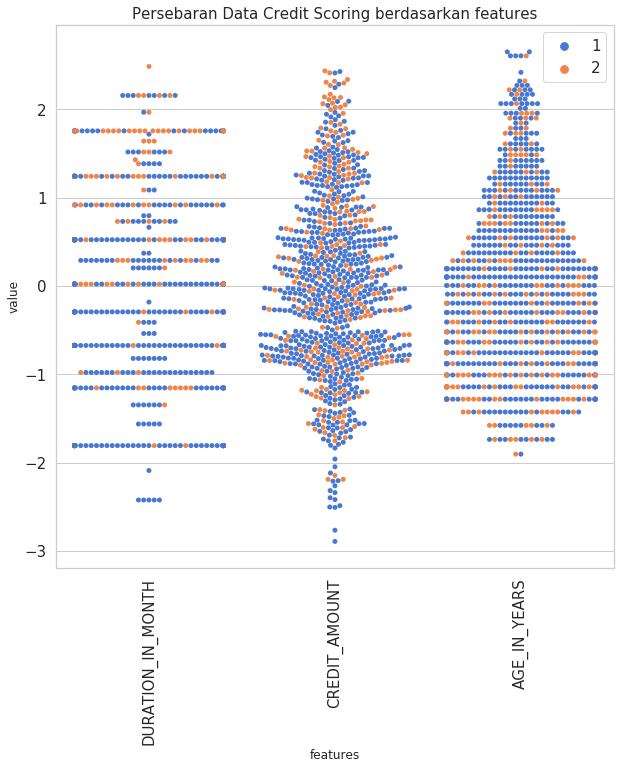

In [0]:
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="CREDIT_SCORE", data=data)
plt.title("Persebaran Data Credit Scoring berdasarkan features", fontsize=15)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90, fontsize=15) 
plt.show()

Dari grafik di atas dapat dilihat variance data dengan lebih jelas. Feature manakah yang kira-kira paling berguna dalam problem klasifikasi ini? Dari grafik di atas, tidak terdapat feature yang mampu menggambarkan klasifikasi ini, karena dari persebaran data terhadap target tidak separable. Hal ini sudah dibuktikan dengan menggunakan violin plot dan swarm plot

# Correlation between numerical data using Heatmap

In [0]:
# Concat numerical and categorical
feature_df = pd.concat([num_feature_df, cat_feature_df], axis=1)

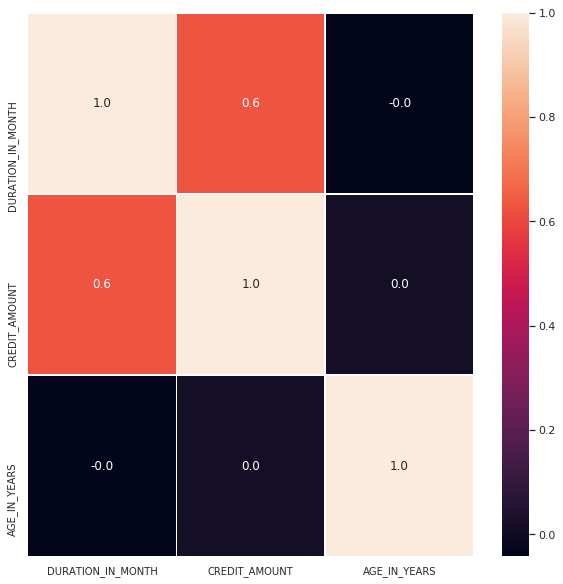

In [0]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(feature_df.corr(), annot=True, linewidths=0.5, fmt='.1f', ax=ax)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

Jika kita lihat pada correlation heatmap di atas, terdapat feature yang terkorelasi karena ada yang memiliki nilai pearson > 0.5 antar features. Jika ada, sebaiknya salah satu variabel tersebut didrop. Feature **CREDIT_AMOUNT** atau **DURATION_IN_MONTH** salah satunya harus didrop. Sebelum didrop kita akan crosscheck dengan menggunakan **joinplot**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


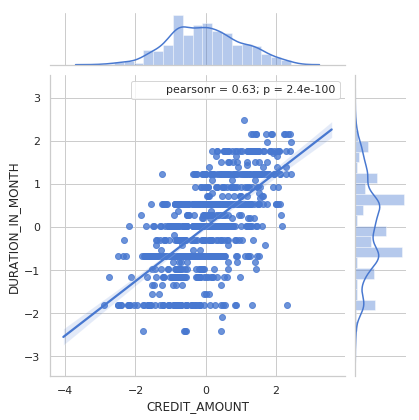

In [0]:
# Show correlation between 2 feature using jointplot
graph = sns.jointplot(feature_df.loc[:,'CREDIT_AMOUNT'], feature_df.loc[:,'DURATION_IN_MONTH'], kind='regg')
graph.annotate(pearsonr)
plt.show()

Setelah di cek dengan jointplot ternyata feature "CREDIT_AMOUNT" dan "DURATION_IN_MONTH" berkorelasi dan memilik nilai pearsonr = 0.63

In [0]:
# Drop Feature
num_feature_df = num_feature_df.drop(['DURATION_IN_MONTH'],axis=1)
feature_df = feature_df.drop(['DURATION_IN_MONTH'],axis=1)

In [0]:
# Concat numerical and categorical
feature_df = pd.concat([num_feature_df, cat_feature_df], axis=1)

# DATA CORRELATION for CATEGORICAL DATA

Introducing: Cramér’s V. It is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:

- Similarly to correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t)
- Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

In [0]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sp.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

##Check hypothesis correlation between all categorical feature to CREDIT_SCORE

In [0]:
list_cramersv = []
for a in cat_feature_df.columns:
  out = cramers_v(cat_feature_df[a], data_df.CREDIT_SCORE)
  list_cramersv.append([a,out])    
  print("Correlation between CREDIT_SCORE and",a,"=",out)

Correlation between CREDIT_SCORE and STATUS_OF_EXISTING_CHECKING_ACCOUNT = 0.3499547831265663
Correlation between CREDIT_SCORE and CREDIT_HISTORY = 0.23557286286745668
Correlation between CREDIT_SCORE and PURPOSE = 0.1683634066941537
Correlation between CREDIT_SCORE and SAVINGS_ACCOUNT/BONDS = 0.17211714111110976
Correlation between CREDIT_SCORE and PRESENT_EMPLOYMENT_SINCE = 0.11666682388275909
Correlation between CREDIT_SCORE and INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME = 0.06169897616546181
Correlation between CREDIT_SCORE and PERSONAL_STATUS_AND_SEX = 0.10428594729230263
Correlation between CREDIT_SCORE and OTHER_DEBTORS/GUARANTORS = 0.054364176676363
Correlation between CREDIT_SCORE and PRESENT_RESIDENCE_SINCE = 0.0
Correlation between CREDIT_SCORE and PROPERTY = 0.12003214929435563
Correlation between CREDIT_SCORE and OTHER_INSTALLMENT_PLANS = 0.08313363139376613
Correlation between CREDIT_SCORE and HOUSING = 0.11532357476783639
Correlation between CREDIT_SCORE and NUM

In [0]:
# Sorting ascending the cramersv value
# take second element for sort
def takeSecond(elem):
    return elem[1]
  
list_cramersv.sort(key=takeSecond)

In [0]:
list_cramersv

[['PRESENT_RESIDENCE_SINCE', 0.0],
 ['NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK', 0.0],
 ['JOB', 0.0],
 ['NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENANCE_FOR', 0.0],
 ['TELEPHONE', 0.035876574652427023],
 ['OTHER_DEBTORS/GUARANTORS', 0.054364176676363],
 ['INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME', 0.06169897616546181],
 ['FOREIGN_WORKER', 0.07472772375337902],
 ['OTHER_INSTALLMENT_PLANS', 0.08313363139376613],
 ['PERSONAL_STATUS_AND_SEX', 0.10428594729230263],
 ['HOUSING', 0.11532357476783639],
 ['PRESENT_EMPLOYMENT_SINCE', 0.11666682388275909],
 ['PROPERTY', 0.12003214929435563],
 ['PURPOSE', 0.1683634066941537],
 ['SAVINGS_ACCOUNT/BONDS', 0.17211714111110976],
 ['CREDIT_HISTORY', 0.23557286286745668],
 ['STATUS_OF_EXISTING_CHECKING_ACCOUNT', 0.3499547831265663]]

In [0]:
drop_col = []
for a in cat_feature_df.columns:
  out = cramers_v(cat_feature_df[a], data_df.CREDIT_SCORE)
  if out < 0.05 :
    drop_col.append(a)
    print("Correlation between CREDIT_SCORE and",a,"=",out)  

Correlation between CREDIT_SCORE and PRESENT_RESIDENCE_SINCE = 0.0
Correlation between CREDIT_SCORE and NUMBER_OF_EXISTING_CREDITS_AT_THIS_BANK = 0.0
Correlation between CREDIT_SCORE and JOB = 0.0
Correlation between CREDIT_SCORE and NUMBER_OF_PEOPLE_BEING_LIABLE_TO_PROVIDE_MAINTENANCE_FOR = 0.0
Correlation between CREDIT_SCORE and TELEPHONE = 0.035876574652427023


## Drop feature which has cramers_v value below 0.05

In [0]:
cat_feature_df = cat_feature_df.drop(drop_col,axis=1)# Drop Feature

##Check correlation between all categorical feature

In [0]:
# Correlation between Features
correlate = []
for i in cat_feature_df.columns:
  for j in cat_feature_df.columns:
    if i !=j :
      out = cramers_v(cat_feature_df[i], cat_feature_df[j])
      print("Correlation between ",i,"and ",j,"= ", out)
      if out > 0.5:
        correlate.append([i,j,out])
  print("\n\n")

Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  CREDIT_HISTORY =  0.1241400720044341
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  PURPOSE =  0.11152363155655905
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  SAVINGS_ACCOUNT/BONDS =  0.1633050081474565
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  PRESENT_EMPLOYMENT_SINCE =  0.0728105642795287
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME =  0.0
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  PERSONAL_STATUS_AND_SEX =  0.00684139177389482
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  OTHER_DEBTORS/GUARANTORS =  0.08620656863047232
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  PROPERTY =  0.03896971893308431
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  OTHER_INSTALLMENT_PLANS =  0.0
Correlation between  STATUS_OF_EXISTING_CHECKING_ACCOUNT and  HOUS

In [0]:
print(correlate)

[['PROPERTY', 'HOUSING', 0.5568554067166162], ['HOUSING', 'PROPERTY', 0.5568554067166162]]


Berdasarkan hasil diatas terdapat nilai **Cramers_V** > 0.5 yaitu korelasi antara feature "**PROPERTY**" dengan "**HOUSING**". Oleh karena itu akan kita drop salah satu featurenya

## Drop categorical data which have correlation

In [0]:
cat_feature_df = cat_feature_df.drop(['HOUSING'],axis=1)# Drop Feature

In [0]:
cat_feature_df.columns

Index(['STATUS_OF_EXISTING_CHECKING_ACCOUNT', 'CREDIT_HISTORY', 'PURPOSE',
       'SAVINGS_ACCOUNT/BONDS', 'PRESENT_EMPLOYMENT_SINCE',
       'INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME',
       'PERSONAL_STATUS_AND_SEX', 'OTHER_DEBTORS/GUARANTORS', 'PROPERTY',
       'OTHER_INSTALLMENT_PLANS', 'FOREIGN_WORKER'],
      dtype='object')

## Save data which categorical feature still in label format (ex : A14, A65)

In [0]:
# Concat numeric and categorical feature
feature_catraw = pd.concat([num_feature_df, cat_feature_df], axis=1)
# Concat all feature with target
data_unpreprocessing = pd.concat([feature_catraw,target_df],axis=1)
# Save data to Excel format
data_unpreprocessing.to_excel("drive/My Drive/Colab Notebooks/credit_scoring/data_unpreprocessing.xlsx", index=False)

# DATA TRANSFORMATION

In [0]:
cat_feature_df.head(2)

,STATUS_OF_EXISTING_CHECKING_ACCOUNT,CREDIT_HISTORY,PURPOSE,SAVINGS_ACCOUNT/BONDS,PRESENT_EMPLOYMENT_SINCE,INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME,PERSONAL_STATUS_AND_SEX,OTHER_DEBTORS/GUARANTORS,PROPERTY,OTHER_INSTALLMENT_PLANS,FOREIGN_WORKER
0,A11,A34,A43,A65,A75,4.0,A93,A101,A121,A143,A201
1,A12,A32,A43,A61,A73,2.0,A92,A101,A121,A143,A201


## Convert Categorical data with format Text to Number

Ordinal Categorical data :
- STATUS_OF_EXISTING_CHECKING_ACCOUNT
- SAVINGS_ACCOUNT/BONDS
- PRESENT_EMPLOYMENT_SINCE
- INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME (**already number**), exception

Nominal Categorical data :
- CREDIT_HISTORY
- PURPOSE
- PERSONAL_STATUS_AND_SEX
- OTHER_DEBTORS/GUARANTORS
- PROPERTY
- OTHER_INSTALLMENT_PLANS
- FOREIGN_WORKER

##Label Encoder for Ordinal Categorical Data

In [0]:
ordinal = ['STATUS_OF_EXISTING_CHECKING_ACCOUNT', 'SAVINGS_ACCOUNT/BONDS', 'PRESENT_EMPLOYMENT_SINCE', 'INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME']
label = {'A14':0, 'A11':1, 'A12':2, 'A13':3, 'A65':0, 'A61':1, 'A62':2, 'A63':3, 'A64':4, 'A71':0, 'A72':1, 'A73':2, 'A74':3, 'A75':4}

ordinal_cat = cat_feature_df[ordinal]
ordinal_cat = ordinal_cat.replace(label)

In [0]:
ordinal_cat.head(3)

,STATUS_OF_EXISTING_CHECKING_ACCOUNT,SAVINGS_ACCOUNT/BONDS,PRESENT_EMPLOYMENT_SINCE,INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME
0,1,0,4,4.0
1,2,1,2,2.0
2,0,1,3,2.0


## One Hot Encoder for Nominal Categorical Data

In [0]:
nominal = ['CREDIT_HISTORY', 'PURPOSE', 'PERSONAL_STATUS_AND_SEX', 'OTHER_DEBTORS/GUARANTORS', 'PROPERTY', 'OTHER_INSTALLMENT_PLANS', 'FOREIGN_WORKER']

nominal_cat = cat_feature_df[nominal]
nominal_cat = pd.get_dummies(nominal_cat,prefix=nominal, drop_first=True)

In [0]:
nominal_cat.head(3)

,CREDIT_HISTORY_A31,CREDIT_HISTORY_A32,CREDIT_HISTORY_A33,CREDIT_HISTORY_A34,PURPOSE_A41,PURPOSE_A410,PURPOSE_A42,PURPOSE_A43,PURPOSE_A44,PURPOSE_A45,PURPOSE_A46,PURPOSE_A48,PURPOSE_A49,PERSONAL_STATUS_AND_SEX_A92,PERSONAL_STATUS_AND_SEX_A93,PERSONAL_STATUS_AND_SEX_A94,OTHER_DEBTORS/GUARANTORS_A102,OTHER_DEBTORS/GUARANTORS_A103,PROPERTY_A122,PROPERTY_A123,PROPERTY_A124,OTHER_INSTALLMENT_PLANS_A142,OTHER_INSTALLMENT_PLANS_A143,FOREIGN_WORKER_A202
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


## Concat nominal and ordinal dataframe

In [0]:
cat_feature_df = pd.concat([ordinal_cat, nominal_cat], axis=1)

## Concat categorical and numerical dataframe

In [0]:
feature_df = pd.concat([num_feature_df, cat_feature_df], axis=1)

## Check result of feature_df

In [0]:
feature_df.head()

,CREDIT_AMOUNT,AGE_IN_YEARS,STATUS_OF_EXISTING_CHECKING_ACCOUNT,SAVINGS_ACCOUNT/BONDS,PRESENT_EMPLOYMENT_SINCE,INSTALLMENT_RATE_IN_PERCENTAGE_OF_DISPOSABLE_INCOME,CREDIT_HISTORY_A31,CREDIT_HISTORY_A32,CREDIT_HISTORY_A33,CREDIT_HISTORY_A34,PURPOSE_A41,PURPOSE_A410,PURPOSE_A42,PURPOSE_A43,PURPOSE_A44,PURPOSE_A45,PURPOSE_A46,PURPOSE_A48,PURPOSE_A49,PERSONAL_STATUS_AND_SEX_A92,PERSONAL_STATUS_AND_SEX_A93,PERSONAL_STATUS_AND_SEX_A94,OTHER_DEBTORS/GUARANTORS_A102,OTHER_DEBTORS/GUARANTORS_A103,PROPERTY_A122,PROPERTY_A123,PROPERTY_A124,OTHER_INSTALLMENT_PLANS_A142,OTHER_INSTALLMENT_PLANS_A143,FOREIGN_WORKER_A202
0,-0.917960,2.270500,1,0,4,4.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1.169591,-1.427793,2,1,2,2.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,-0.169158,1.221464,0,1,3,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1.530170,0.936994,1,1,3,2.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0
4,0.912385,1.484030,1,1,2,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0


In [0]:
feature_df.shape

(900, 30)

In [0]:
data_preprocessing = pd.concat([feature_df,target_df],axis=1)

## Save data which categorical feature already encode to number (Label Encoder and One-Hot-Encoding)

In [0]:
data_preprocessing.to_excel("drive/My Drive/Colab Notebooks/credit_scoring/data_preprocessing.xlsx", index=False)

# Check for linearly separable

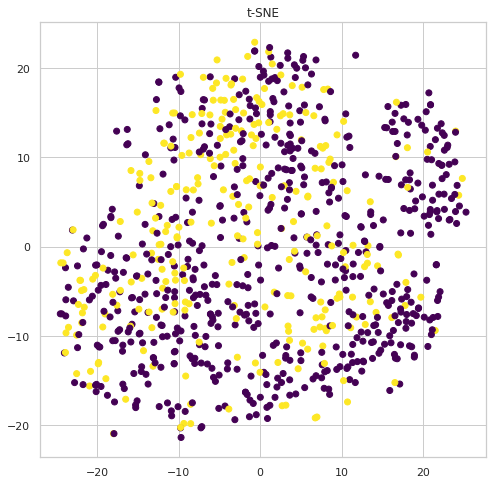

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity = 50)
X_tsne = tsne.fit_transform(feature_df.values)

# Visualize
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=target_df.values, cmap='viridis')
plt.title("t-SNE")
plt.show()

Dari hasil visualisasi 2D menggunakan t-SNE terlihat bahwa data yang kita miliki tidak linearly separable